# Цель проекта: 
1. Собрать данные с сайта cian.ru
2. Добавить данные в Pandas Dataframe
3. Создать модель машинного обучения на основе этих данных

In [1]:
import requests
from PIL import Image
import pandas as pd
from email.message import EmailMessage
import ssl
import smtplib
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## 1. Инициализируем веб-драйвер

In [2]:
path = 'C:\Program Files (x86)\chromedriver.exe'                                        #locating chrome web-driver
driver = webdriver.Chrome(path)  

## 2. Создаем словарь со списками, в который будем добавлять данные

In [3]:
prices = []
info = []
area = []
rooms = []
rem = []
floor = []
info_dict = {'prices': prices, 'area' : area, 'rooms' : rooms, 'remoteness': rem, 'floor': floor}

## 3. Создаем функции, которые извлекают данные с cian.ru

In [4]:
def get_price(html): 
    prices_elems = html.find_all("span", {"data-mark": "MainPrice"}) 
    for element in prices_elems:
        prices.append(element.text)

In [5]:
def info_func(html): 
    info = []
    info_elems = html.find_all("div", {"data-name": "GeneralInfoSectionRowComponent"}) 
    for element in info_elems:
        try:
            info.append(element.find("span", {"data-mark": "OfferSubtitle"}).text)
        except:
            info.append(element.find("span", {"data-mark": "OfferTitle"}).text)
        finally:
            continue
    info1 = list(map(lambda x: x.split(','), info)) # список, в котором хранятся элементы: количество комнат, площадь, этаж
    for i in info1:
        try:
            rooms.append(int(i[0][0]))
        except:
            rooms.append(0)
    for i in info1:
        if 'м²' in i[2]:
            ar = i[2].replace('м²', '')
            ar = ar.strip()
            area.append(f'{i[1]}.{ar}')
        else:
            area.append(i[1].replace('м²', '').strip())
    for i in info1:
        fl = i[-1].split()
        fl = fl[0].split('/')
        floor.append(round(int(fl[0]) / int(fl[1]), 2))

In [6]:
def get_remoteness(html):
    remoteness = html.find_all("div", {"class": "_93444fe79c--remoteness--q8IXp"})
    for i in remoteness:
        rem.append(i.text)
    remoteness.clear()

In [7]:
def area_tofloat(x):
    return float(x.replace(' ', ''))

In [8]:
def prices_toint(x):
    return int(x[:-1].replace(' ', ''))

## 4. Создаем цикл, который применяет функции со страниц сайта 

In [9]:
driver.get('https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D=66&engine_version=2&object_type%5B0%5D=1&offer_type=flat&p=1')
time.sleep(7)
pages = driver.find_elements(By.XPATH, "//li[@class='_93444fe79c--list-item--FFjMz']")
for p in pages:
    try:
        html = BeautifulSoup(driver.page_source, 'html.parser') 
        info_func(html)
        get_price(html)
        get_remoteness(html)
        p.click()
        time.sleep(5)
    except:
        continue
driver.quit()

In [10]:
prices = list(map(lambda x: int(x[:-2].replace(" ", '')), prices))
area = list(map(lambda x: float(x.strip()), area))

In [11]:
info_dict = pd.DataFrame(info_dict)

In [12]:
info_dict['prices'] = info_dict['prices'].apply(prices_toint)
info_dict['area'] = info_dict['area'].apply(area_tofloat)

## 5. Проведем разведовательный анализ данных

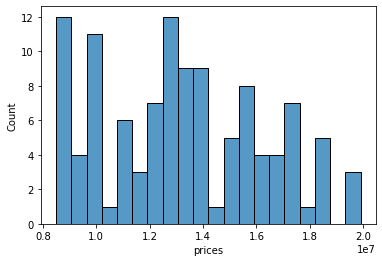

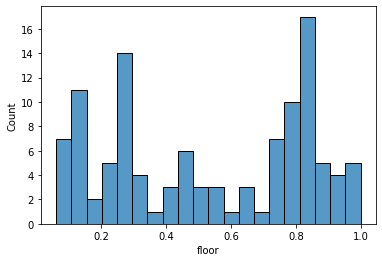

In [13]:
sns.histplot(data=info_dict, x=info_dict['prices'],bins=20)
plt.show()
sns.histplot(data=info_dict, x=info_dict['floor'],bins=20)
plt.show()

In [14]:
df1 = info_dict.groupby('rooms')['prices'].mean().reset_index()

In [15]:
df1['prices'] = df1['prices'].astype(int)

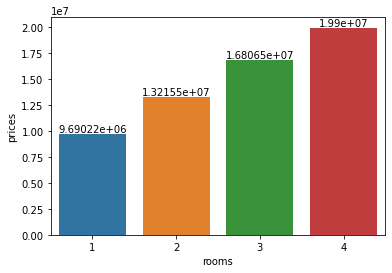

In [16]:
bar1 = sns.barplot(data=df1, x=df1['rooms'], y=df1['prices'])
for container in bar1.containers:
    bar1.bar_label(bar1.containers[0])

Чем больше комнат в квартире, тем выше цена.   
Средняя цена однокомнатной квартиры - 9,6 миллионов, двухкомнатной - 13,3 миллионов, трёхкомнатной - 17 миллионов, четырёхкомнатной - 19 миллионов.

<AxesSubplot:xlabel='area', ylabel='prices'>

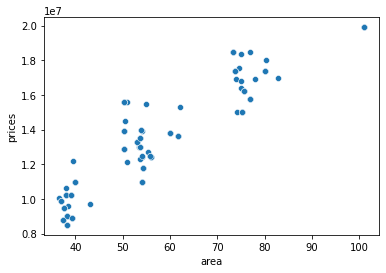

In [17]:
sns.scatterplot(data=info_dict, x=info_dict['area'], y=info_dict['prices'])

Чем больше площадь, тем выше цена.

In [18]:
df2 = info_dict.loc[info_dict['remoteness'].str.contains('пешком')] # удаляем квартиры с указанной дальностью на транспорте, а не пешком

In [19]:
df2['remoteness'] = df2.remoteness.str.extract('(\d+)').astype(int)

In [20]:
df2

,prices,area,rooms,remoteness,floor
0,13900000,54.0,2,8,0.48
1,13990000,53.8,2,14,0.48
3,12399000,54.0,2,9,0.06
4,15300000,62.2,3,13,0.93
5,10050000,36.6,1,3,0.12
...,...,...,...,...,...
106,9500000,37.5,1,18,0.50
108,12500000,55.7,2,15,0.29
109,13500000,53.6,2,9,0.76
110,13800000,60.0,2,6,0.29


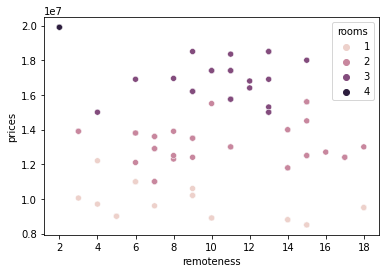

In [21]:
remoteness_plot = sns.scatterplot(data=df2, x=df2['remoteness'], y=df2['prices'], hue=df2['rooms'])

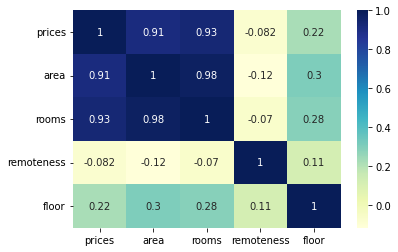

In [22]:
sns.heatmap(df2.corr(), cmap="YlGnBu", annot=True)
plt.show()

Наблюдается корреляция между ценой и количеством комнат, ценой и площадью и площадью с количеством комнат. 

### Построим модель машинного обучения

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [24]:
modelLR = LinearRegression()

In [25]:
X = df2.iloc[:, 1:]
y = df2.iloc[:, :1] 

In [26]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=46)
modelLR.fit(Xtrain, Ytrain)

LinearRegression()

In [27]:
train_y_pred = modelLR.predict(Xtrain)

In [28]:
train_r2 = r2_score(Ytrain, train_y_pred)
train_r2

0.8845039593853636

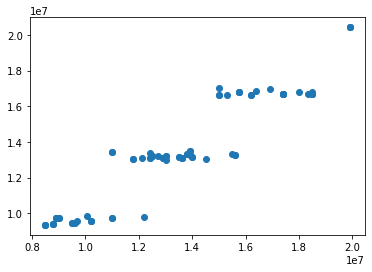

In [29]:
plt.scatter(Ytrain, train_y_pred)
plt.show()

In [30]:
y_test_pred = modelLR.predict(Xtest)

In [31]:
test_r2 = r2_score(Ytest, y_test_pred)
test_r2

0.7891547998113231

Точность модели: 0.79, что является удовлетворительным показателем

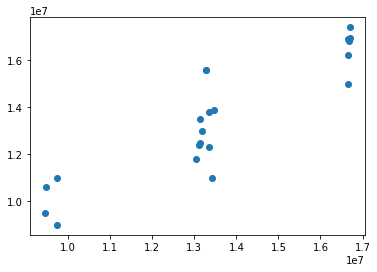

In [33]:
plt.scatter(y_test_pred, Ytest)
plt.show()

Попробуем спрогнозироваь цену квартиры с площадью 56 кв.м., двумя комнатами, в 6 минутах ходьбы от метро и на 5/10 этаже.

In [34]:
modelLR.predict([[56, 2, 6, 0.5]]).round(-3)[0][0]

13269000.0

In [36]:
Ytest1 = Ytest.reset_index()
Ytest1 = Ytest1.drop(columns='index')
Ytest1['prices_pred'] = y_test_pred

In [37]:
from math import sqrt
def sqrt_df(x):
    return sqrt(x)

In [38]:
Ytest1['prices_pred'] = round(Ytest1['prices_pred'], -4)
Ytest1['Sq_deviation'] = ((Ytest1['prices'] - Ytest1['prices_pred'])**2)
Ytest1['Sq_deviation'] = Ytest1['Sq_deviation'].apply(sqrt_df)

In [39]:
Ytest1.head()

,prices,prices_pred,Sq_deviation
0,11000000,13420000.0,2420000.0
1,17400000,16690000.0,710000.0
2,11790000,13040000.0,1250000.0
3,10600000,9480000.0,1120000.0
4,10990000,9730000.0,1260000.0


In [40]:
round(Ytest1.Sq_deviation.mean(), -3)

895000.0

Среднее отклонение в тестовой группе - 895 тыс. руб.